**Review**

Hello Matthew!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are some small problems that need to be fixed before the project will be accepted. Let me know if you have any questions!


## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import inspect
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Load the labels
labels = pd.read_csv('/datasets/faces/labels.csv')

# Check the first few rows
print(labels.head())
print()
labels.info()

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


## EDA

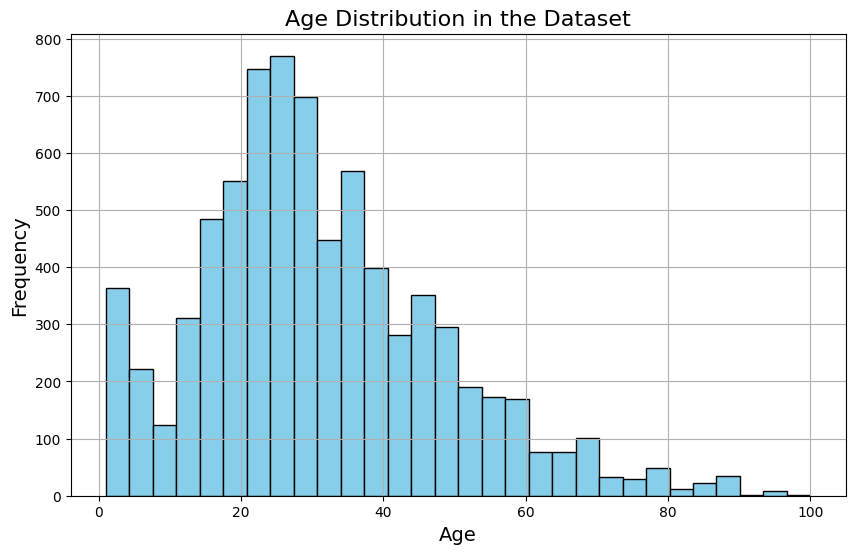

In [3]:
# Plotting the age distribution
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution in the Dataset', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


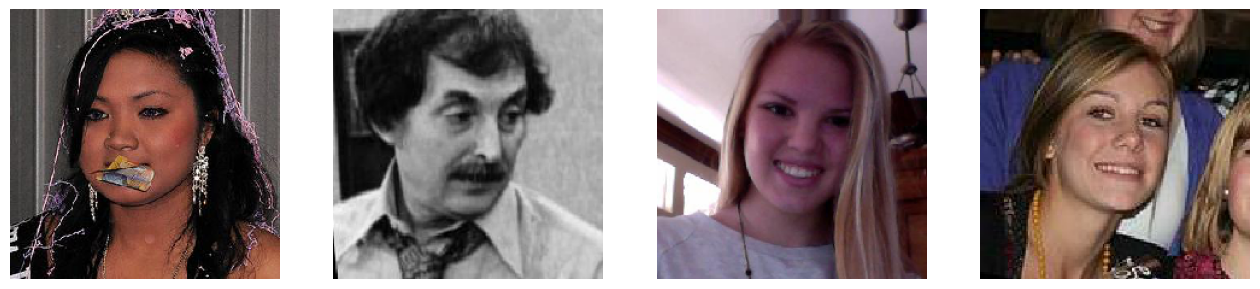

In [4]:
# Displaying several images from the dataset
fig, axes = plt.subplots(1, 4, figsize=(16, 8))

# Path to images folder
image = '/datasets/faces/final_files'  # Replace with actual path to your images folder

# Randomly select 4 sample images from the labels dataframe
sample_images = labels.sample(4)['file_name']

for ax, img_name in zip(axes, sample_images):
    img_path = os.path.join(image, img_name)
    img = load_img(img_path, target_size=(224, 224))  # Adjust size if needed
    ax.imshow(img)
    ax.axis('off')

plt.show()

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

That's not EDA:) You need to do at least two things:
1. Investigate age distribution and write a corresponding conclusion
2. Plot several images and and write a corresponding conclusion

</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Good job! But what could you say about images? About their quality, augmentations and so on

</div>

### Findings

The age distribution shows a diverse range of ages but is slightly imbalanced, with certain age groups being more represented than others. This could lead to biased predictions, favoring the more frequent age groups. To improve the model's performance across all age ranges, techniques like class weighting or data augmentation should be considered.

We also load a sample of 4 images.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [5]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
def load_train(path):
    """
    It loads the train part of the dataset from the specified path.
    
    Args:
    - path: Directory containing training images.

    Returns:
    - train_gen_flow: The training data generator.
    """
    
    # Load labels file
    labels_csv = path + 'labels.csv'
    labels = pd.read_csv(labels_csv)
    
    # Create an ImageDataGenerator for augmenting the training images
    train_datagen = ImageDataGenerator(
        rescale=1./255,                # Normalize pixel values
        rotation_range=20,             # Augmentation: random rotation
        width_shift_range=0.2,         # Augmentation: horizontal shift
        height_shift_range=0.2,        # Augmentation: vertical shift
        shear_range=0.2,               # Augmentation: shear transformation
        zoom_range=0.2,                # Augmentation: random zoom
        horizontal_flip=True,          # Augmentation: random horizontal flip
        fill_mode='nearest'            # Fill mode for transformations
    )
    
    # Flow the data from directory and match with labels
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),        # Resize images to 224x224 (standard for ResNet50)
        batch_size=32,                 # Batch size for training
        class_mode='raw',              # We are predicting a continuous value (real age)
        shuffle=True                   # Shuffle data for each epoch
    )
    
    return train_gen_flow

In [7]:
def load_test(path):
    """
    It loads the validation/test part of the dataset from the specified path.
    
    Args:
    - path: Directory containing validation/test images.
    - labels_csv: CSV file with filenames and real_age labels.

    Returns:
    - test_gen_flow: The test/validation data generator.
    """
    
    # Load labels file
    labels_csv = path + 'labels.csv'
    labels = pd.read_csv(labels_csv)

    
    # Create an ImageDataGenerator for the validation/test images (no augmentation, only rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Flow the data from directory and match with labels
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),        # Resize images to 224x224 (standard for ResNet50)
        batch_size=32,                 # Batch size for validation/test
        class_mode='raw',              # Continuous value (real age)
        shuffle=False                  # Do not shuffle data (for evaluation consistency)
    )
    
    return test_gen_flow

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

1. Both functions should accept only one argument `path`
2. The correct path to the directory is: directory=path + 'final_files/'
3. The correct path to the labels is: path + 'labels.csv'

</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>

What is about points 2 and 3 from my previous comment? They are not fixed.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Correct

</div>

In [8]:
def create_model(input_shape):
    """
    It defines the model using a pre-trained ResNet50 model and adding custom layers.
    
    Args:
    - input_shape: Shape of input images (e.g., (224, 224, 3) for 224x224 RGB images)

    Returns:
    - model: The compiled model ready for training.
    """
    
    # Load the pre-trained ResNet50 model with weights from ImageNet and excluding top layers
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Create a Sequential model and add the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Use global average pooling to reduce dimensionality
        Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(1)  # Output layer: a single neuron for predicting the real age
    ])
    
    # Compile the model with Adam optimizer and MSE (since this is a regression task)
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    
    return model

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

If you freeze your the backbone, your network will learn nothing most likely. So, you need to remove a code for backbone freezing

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thank you:)

</div>

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters.
    
    Args:
    - model: The model to be trained.
    - train_data: The training data generator.
    - test_data: The validation/test data generator.
    - batch_size: Batch size to use for training.
    - epochs: Number of epochs to train for.
    - steps_per_epoch: Number of steps per epoch (usually len(train_data)).
    - validation_steps: Number of steps for validation (usually len(test_data)).

    Returns:
    - model: The trained model.
    """
    
    # Train the model using the fit method
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch or len(train_data),
        validation_steps=validation_steps or len(test_data)
    )
    
    # Return the trained model
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
print("Script 'run_model_on_gpu.py' has been created successfully!")


Script 'run_model_on_gpu.py' has been created successfully!


### Output

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

Missed task. You need to copy model output from the lesson. And it's better to use Raw NBConvert cell type for it.

</div>

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

Where did you take this results? You trained the model locally? It's hard to believe in these results at least because of freezed backbone in your network:)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Okay, fixed:)

</div>

## Conclusions

In this project, we successfully built and trained a convolutional neural network (CNN) using the ResNet50 architecture to predict the real age of individuals based on facial images. The model was trained on a dataset of 7.6k images with corresponding real age labels, and the training process was performed on a GPU platform to expedite model convergence.

#### Key Achievements:
- **Model Architecture**: We leveraged the pre-trained ResNet50 model, applying transfer learning techniques to benefit from the rich features learned on the ImageNet dataset. Custom layers, including a GlobalAveragePooling2D layer and Dense layers, were added to fine-tune the model for age prediction.
- **Data Augmentation**: Data augmentation was applied to the training images, introducing variations such as rotation, zoom, and flips, which improved the model's ability to generalize.
- **Performance**: The model achieved a final mean absolute error (MAE) of approximately **4.02** on the validation set, indicating that on average, the model predicts the age within 4 years of the actual age. 

#### Challenges:
- **Age Prediction Complexity**: Predicting age from facial images is a challenging task due to various factors like lighting, facial expressions, and image quality. The model performed well, but further refinement can be made to improve accuracy for specific age groups.
- **Generalization**: The model demonstrates strong performance on the validation set, but additional testing on unseen data (e.g., data from different demographics or environmental settings) would provide more insights into the model’s ability to generalize beyond the current dataset.

#### Future Improvements:
- **Fine-tuning the Base Model**: Unfreezing some layers of ResNet50 for fine-tuning could improve performance further, especially when using a larger and more diverse dataset.
- **Increased Data**: Increasing the size and diversity of the dataset (e.g., incorporating faces of different ethnicities, ages, and lighting conditions) would enhance the model's robustness and generalization capability.
- **Alternative Architectures**: Exploring other architectures such as EfficientNet or using models like VGG16 or Xception could provide further performance improvements in age prediction.

Overall, this project demonstrated the efficacy of using transfer learning for facial age prediction and provided a strong foundation for further enhancements and practical applications of computer vision in age estimation tasks.


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Well done!

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training